# Comparing Cross Entropy and Mean Squared Error for Classification Loss

The [Machine Learning course on Coursera by Andrew Ng](https://www.coursera.org/learn/machine-learning), discusses the need for convex loss function for fitting the parameters of the model or hypothesis function $y = h_\theta(x)$.

For binary classification the hypothesis function is the sigmoid function $\sigma (z) = 1/(1+e^{-z})$. 

Finding the global minimum of a convex function is certainly the better than non-convex function that have global minimum in addition to several local minima. In this course, Andrew Ng mentions that because the hypothesis function is non-linear,  the mean squared error 
$$ \frac{1}{2m} \sum_{i = 1}^{m} \left(h_\theta(x^{(i)}) - y^{(i)} \right)^2 $$
is a non-convex function that has many local minima. He then provides an alternative loss/cost function:

$$ C(\theta) = \left\{
\begin{array} \\ 
  \begin{align*}  & -\log(h_\theta(x))  \,\,\,  & \text{if} \,\, y=1 \\ 
                               & -\log(1-h_\theta(x)) \,\,\,  & \text{if} \,\, y=0 
                        \end{align*} 
\end{array} \right.
$$
and very nicely shows that its convex over its permissible values. 

The cost function can be rewritten in one line as follows: 

$$ C(\theta) = - y  \log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))$$ where $y$ takes only 0 or 1 as values.

The cross entropy loss function over all examples then is given by:
$$ \frac{1}{m} \sum_{i = 1}^{m} \left(  - y^{(i)}  \log(h_\theta(x^{(i)})) - (1-y^{(i)})\log(1-h_\theta(x^{(i)})) \right)$$

The cross entropy happens to be the log likelihood of the binomial distribution of this binary classification problem. 

The goal of this note is to look at an example comparing the performance of the model using both loss functions and visualizing them in the parameter space $(\theta_0, \theta_1)$

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn import datasets
from scipy import optimize
import matplotlib.pyplot as plt

from utils import *

from sklearn.model_selection import train_test_split

%matplotlib inline

### Create the dataset 

We create the dataset that we are working with using scikit-learn tool. 
For visualzation purposes we want only one feature. 

In [2]:
X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=1,
                   random_state=0)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4, random_state = 1235)


(1000, 1)


Let's visualize the training and test data

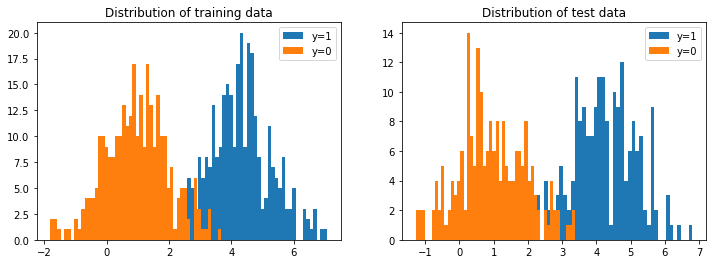

In [3]:

plt.subplots(1,2, figsize = (12,4))
plt.subplot(121)
plt.hist(X_train[y_train==1], bins = 50)
plt.hist(X_train[y_train==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of training data')

plt.subplot(122)
plt.hist(X_test[y_test==1], bins = 50)
plt.hist(X_test[y_test==0], bins = 50)
plt.legend(['y=1', 'y=0'])
plt.title('Distribution of test data')
plt.show()

The hypothesis function has the form:
$$ h_\theta(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x))}$$

to account for the intercept term in $\theta_0 + \theta_1 x$ we add a column of ones to the data matrix X

In [4]:
X_train_o = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test_o = np.hstack((np.ones((X_test.shape[0],1)),X_test))

We define below the cross entropy cost function and mean square error cost function 

In [5]:

def costFunction(theta, X, y):
    '''
    We define here the cross entropy loss function
    takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(y)  
    
    #initialize loss J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    z = np.matmul(theta,X.T)
    pred = sigmoid(z)
    
    # for visualization purposes we do not want the pred
    # to take 1 or 0 values so that the log(pre) and 
    # log(1-pred) do not taake -inf values. 
    pred[pred > 0.999] = pred[pred>0.999] - 1e-10
    pred[pred < 0.001] = pred[pred<0.001] + 1e-10
    
    # cross entropy loss
    J = (-1/m)*((np.dot(y,np.log(pred)))+ np.dot(1-y,np.log(1-pred))) 
    
    # the gradient of the J with respect to theta
    grad = (1/m) * np.matmul((pred-y).T,X)
    
    
    return J, grad


def costFunction_MSE(theta, X,y):
    '''
    We define here the mean squared error loss function.
    it takes X, y and theta as parameters. the values 
    of theta define the model it self.
    Their dimensions are as follows:
    X : (m,2), y: (m,1), theta: (1,2)
    
    returns the loss and the gradient of the loss
    '''
    #constants
    m = len(y)
    
    #initialize J and its gradient
    J = 0
    grad = np.zeros(theta.shape)
    
    # cost function using vectorization
    
    z = np.matmul(theta,X.T)
    pred = sigmoid(z)
    
    J = (1/(2*m))* np.dot(y-pred, y-pred)
    
    # gradient of J with respect to theta has extra
    # step of computing h'
    hp = sigmoid_grad(z)
    grad = (-1/m) * np.matmul((hp*(y-pred)).T,X)
    
    return J, grad


### Optimization (minimization) Algorithm(s): 

To find or learn theta that best fits the data, we minimize the loss function using two algorithms. The gradient descent and the truncated Newton method. 
Below we define the gradient descent algorithm.

In [6]:
def gradientDescent(X, y, theta, alpha, num_iter):
    '''
    The algorithm takes X, y and theta as well as
    alpha (the learning rate or step size) and the 
    number of iterations
    It returns the optimal theta that minimizes the loss
    function as well as a record of loss values and thetas
    per iteration. 
    '''
    m = len(y)
    J_history = np.zeros(num_iter)
    theta_hist = []
    for itern in range(num_iter):
        J,grad = costFunction(theta, X,y)
        theta = theta - alpha*grad
        J_history[itern] = J
        theta_hist.append(theta)
        
    return theta, J_history, theta_hist

def gradientDescent_MSE(X, y, theta, alpha, num_iter):
    '''
    The algorithm takes X, y and theta as well as
    alpha (the learning rate or step size) and the 
    number of iterations
    It returns the optimal theta that minimizes the loss
    function as well as a record of loss values and thetas
    per iteration. 
    '''
    m = len(y)
    J_history = np.zeros(num_iter)
    theta_hist = []
    for itern in range(num_iter):
        J,grad = costFunction_MSE(theta, X,y)
        theta = theta - alpha*grad
        J_history[itern] = J
        theta_hist.append(theta)
        
    return theta, J_history, theta_hist

Now we run the **gradient descent algorithm** for both loss function and print out the optimal theta

In [7]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
theta_ce, J_hist_ce, theta_hist_ce = gradientDescent(X_train_o,y_train,theta_0, 0.1, 15000)
theta_ce_lr1, J_hist_ce_lr1, theta_hist_ce_lr1 = gradientDescent(X_train_o,y_train,theta_0, 1.0, 15000)

In [8]:
epsilon = 0.01
np.random.seed(32435)
theta_0 = np.random.uniform(-epsilon, epsilon, 2)
theta_mse, J_hist_mse, theta_hist_mse = gradientDescent_MSE(X_train_o,y_train,theta_0, 0.1, 20000)
theta_mse_lr1, J_hist_mse_lr1, theta_hist_mse_lr1 = gradientDescent_MSE(X_train_o,y_train,theta_0, 1, 20000)

In [9]:
print('theta using cross entropy (lr = 0.1): ',theta_ce)
print('theta using cross entropy (lr = 1.0): ',theta_ce_lr1)
print('theta using MSE (lr = 0.1): ', theta_mse)
print('theta using MSE (lr= 1.0): ', theta_mse_lr1)

theta using cross entropy (lr = 0.1):  [-9.06314984  3.40563625]
theta using cross entropy (lr = 1.0):  [-9.46900886  3.54876697]
theta using MSE (lr = 0.1):  [-5.93496463  2.26586209]
theta using MSE (lr= 1.0):  [-8.43398832  3.17118404]


First we check plots of the loss function. I have run the MSE loss function using the same learning rate 0.1 but it did not converge fast enough to the best value. So I tried learning rate of 1.0 and found it converged faster, as the plot shows.

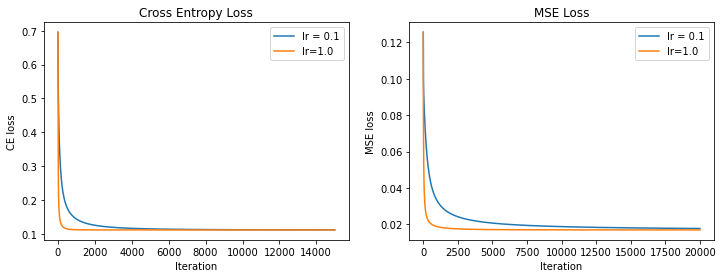

In [10]:
plt.subplots(1,2,figsize= (12,4))
plt.subplot(121)
plt.plot(J_hist_ce)
plt.plot(J_hist_ce_lr1)
plt.legend(['lr = 0.1', 'lr=1.0'])
plt.title('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('CE loss')

plt.subplot(122)
plt.plot(J_hist_mse)
plt.plot(J_hist_mse_lr1)
plt.legend(['lr = 0.1', 'lr=1.0'])
plt.title('MSE Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.show()

**For visualization** we choose a few values of thetas leading to the minimum. 

In [11]:
th_ce_short_list = [theta_hist_ce_lr1[i] for i in range(0,600,100)]
[th_ce_short_list.append(theta_hist_ce_lr1[i]) for i in range(1000,15000,2000)]

ths1 = []
ths2 = []
for i in range(len(th_ce_short_list)):
    ths1.append(th_ce_short_list[i][0])
    ths2.append(th_ce_short_list[i][1])

In [12]:
th_mse_short_list = [theta_hist_mse_lr1[i] for i in range(0,8000,1000)]
[th_mse_short_list.append(theta_hist_mse_lr1[i]) for i in range(8000,20000,2000)]

ths11 = []
ths22 = []

for i in range(len(th_mse_short_list)):
    ths11.append(th_mse_short_list[i][0])
    ths22.append(th_mse_short_list[i][1])

Now we run the **truncated Newton method** which is faster and more efficient.

In [13]:
# optimization code is copied from https://github.com/dibgerge/ml-coursera-python-assignments/exercise2
# set options for optimize.minimize
options= {'maxiter': 10000}

epsilon = 4
np.random.seed(32435)
initial_theta = np.random.uniform(-epsilon, epsilon, 2)


# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res_ce = optimize.minimize(costFunction,
                        initial_theta,
                        (X_train_o, y_train),
                        jac=True,
                        method='TNC',
                        options=options)

res_mse = optimize.minimize(costFunction_MSE,
                        initial_theta,
                        (X_train_o, y_train),
                        jac=True,
                        method='TNC',
                        options=options)


# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost_ce2 = res_ce.fun

# the optimized theta is in the x property
theta_ce2 = res_ce.x

cost_mse2 = res_mse.fun
theta_mse2 = res_mse.x

Here are the results

In [14]:
print('Minimization using truncated Newton method')

print('\n Results using Cross Entropy loss')
print('\n \t theta ', theta_ce2)
print(' \t cost ', cost_ce2)
print('\t decision boundary : y = 1 if  x >= % 2.3f' %(-theta_ce2[0]/theta_ce2[1]))

print('\n Results using MSE loss')
print('\n \t theta ', theta_mse2)
print(' \t cost ', cost_mse2)
print('\t decision boundary : y = 1 if x >= % 2.3f' %(-theta_mse2[0]/theta_mse2[1]))


Minimization using truncated Newton method

 Results using Cross Entropy loss

 	 theta  [-9.46810766  3.54844152]
 	 cost  0.1122807275105055
	 decision boundary : y = 1 if  x >=  2.668

 Results using MSE loss

 	 theta  [-8.67102089  3.25777273]
 	 cost  0.01692208352634124
	 decision boundary : y = 1 if x >=  2.662


## Classification Results
From the values of the decision boundary, we see that the results using the two methods would be very similar. But lets compute the exact values of standard classification metrics.

First we look at the cross entropy loss results

In [39]:
results(X_test_o,y_test,theta_ce)

False negatives  14
false positive  12
true negatives  190
true positives  184
total true values  374


precision 0.9388
recall 0.9293
accuracy  0.9350 
F1 score  0.9340 


All metrics look very good, almost perfect. 

Now we look at the MSE loss results, we expect them to be not far from the above.

In [40]:
results(X_test_o,y_test,theta_mse)

False negatives  14
false positive  13
true negatives  189
true positives  184
total true values  373


precision 0.9340
recall 0.9293
accuracy  0.9325 
F1 score  0.9316 


# Visualizatioin Of Loss Funtions

Now its time to turn our attention to the loss functions. We will look at slices in near the optimal $\theta$. One slice in $\theta_0$ direction and another in $\theta_1$ direction. We will also plot the loss functions in three dimensions. We want to check convexity property. If not convex are there other local minima. 
We start with the cross entropy loss function. 


## Profile Visualization Of Cross Entropy Loss

First we look at profile (slice) along each axis. Next we plot contour and surface in 3d.

I emphasize here that these plots are of the modified sigmoid whose image lies not between 0 and 1 but rather between 1 - 1e-10 and 0 + 1e-10. I did this to extend the domain of permissible values of the cross entropy loss function.

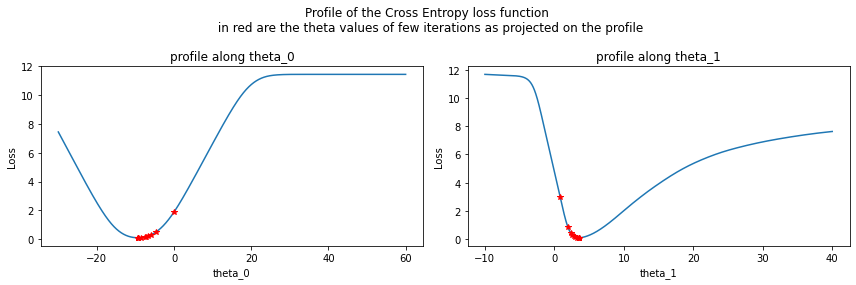

In [72]:
# Preparing data range for profile plots        
th1_1 = np.arange(-30,60,0.01)
th2_1 = theta_ce2[1]

J_t1, J_tt1 = utils.get_profile(costFunction, X_train_o, y_train, th1_1, th2_1, ths1, ths2, 'theta_0') 

th1_2 = theta_ce2[0]
th2_2 = np.arange(-10,40,0.01)

J_t2, J_tt2 = utils.get_profile(costFunction, X_train_o, y_train, th1_2, th2_2, ths1, ths2, 'theta_1') 

utils.plot_profiles(th1_1, th2_2, ths1, ths2, J_t1, J_tt1, J_t2, J_tt2, 'Cross Entropy')

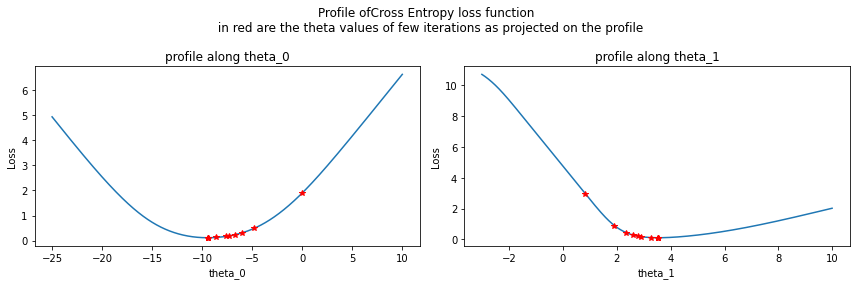

In [70]:
# Preparing data range for profile plots        
th1_1 = np.arange(-25,10,0.01)
th2_1 = theta_ce2[1]

J_t1, J_tt1 = utils.get_profile(costFunction, X_train_o, y_train, th1_1, th2_1, ths1, ths2, 'theta_0') 

th1_2 = theta_ce2[0]
th2_2 = np.arange(-3,10,0.01)

J_t2, J_tt2 = utils.get_profile(costFunction, X_train_o, y_train, th1_2, th2_2, ths1, ths2, 'theta_1') 

utils.plot_profiles(th1_1, th2_2, ths1, ths2, J_t1, J_tt1, J_t2, J_tt2, 'Cross Entropy')

In [71]:
import utils
import importlib
importlib.reload(utils)


<module 'utils' from 'C:\\Users\\Hala\\Documents\\DeepLearning\\Nahil_Sobh\\ML_training_git\\CE_MSE_comparison\\utils.py'>

# Profile Visualization of MSE Loss

Here we compare the above with MSE loss profiles. We consider the Zoomed out view first and then an Zoomed in view. 

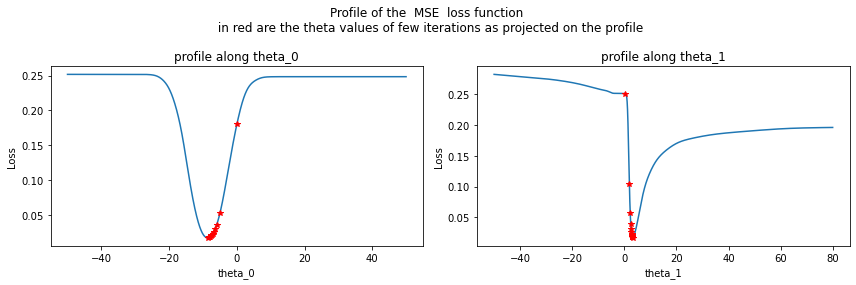

In [74]:
th1_m1 = np.arange(-50,50,0.01)
th2_m1 = theta_mse2[1]

K_t1, K_tt1 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m1, th2_m1, ths11, ths22, 'theta_0') 

th1_m2 = theta_mse2[0]
th2_m2 = np.arange(-50,80,0.01)

K_t2, K_tt2 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m2, th2_m2, ths11, ths22, 'theta_1')

utils.plot_profiles(th1_m1, th2_m2, ths11,ths22, K_t1, K_tt1, K_t2, K_tt2, ' MSE ')

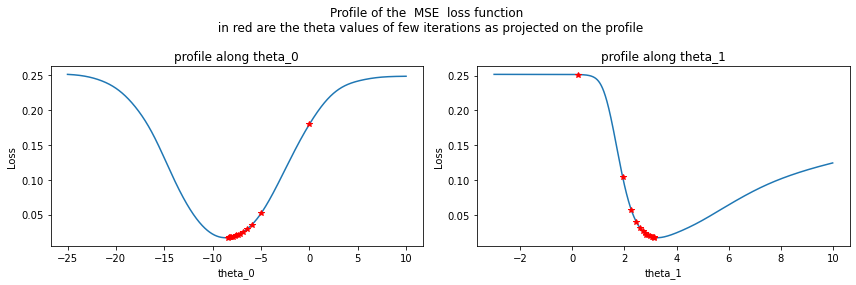

In [75]:
th1_m1 = np.arange(-25,10,0.01)
th2_m1 = theta_mse2[1]

K_t1, K_tt1 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m1, th2_m1, ths11, ths22, 'theta_0') 

th1_m2 = theta_mse2[0]
th2_m2 = np.arange(-3,10,0.01)

K_t2, K_tt2 = utils.get_profile(costFunction_MSE, X_train_o, y_train, th1_m2, th2_m2, ths11, ths22, 'theta_1')

utils.plot_profiles(th1_m1, th2_m2, ths11,ths22, K_t1, K_tt1, K_t2, K_tt2, ' MSE ')

# 3D **Visualizations** of Loss Functions

Three dimensional view of the surface allow us to see the globale minima, convexity proporty if any. 

The contour view aids in understanding the surface where its is not so clear. 

## Cross Entropy Loss: surface and contour
 

In [18]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-20,0,401),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-1,6,401),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)


J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, X_train_o, y_train)

In [23]:
Js12 = np.zeros(len(ths1))
for i in range(len(ths1)):
    theta = np.array([ths1[i], ths2[i]])
    Js12[i], _ = costFunction(theta, X_train_o,y_train)

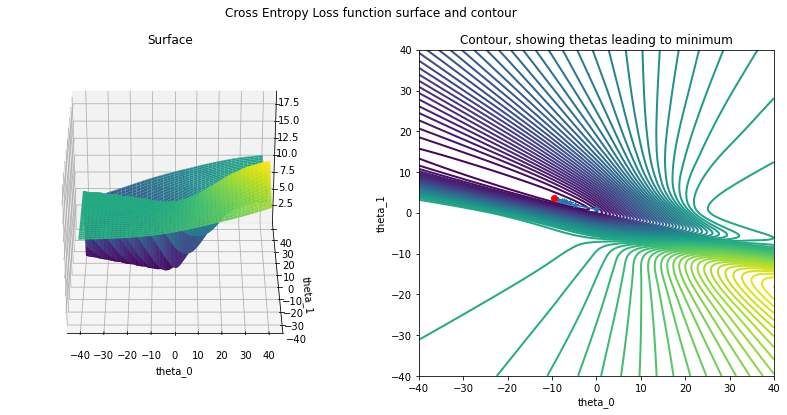

In [45]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x12, x21, J12, cmap='viridis', linewidth=0.2)
ax.view_init(30,-90)
#ax.plot(ths1, ths2,Js12,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(x1, x2, J12, linewidths=2, cmap='viridis', levels = 70)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths1, ths2, '-*')
plt.plot(theta_ce2[0],theta_ce2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')

plt.suptitle('Cross Entropy Loss function surface and contour')
plt.show()

In [23]:
# good view using x1: [-12,6], x2: [-6, 12]
x1 = np.sort(np.concatenate((np.linspace(-40,40,601),np.array(ths1))))
x2 = np.sort(np.concatenate((np.linspace(-40,40,601),np.array(ths2))))
x12, x21 = np.meshgrid(x1, x2)

J12 = np.zeros((x12.shape[0],x21.shape[0]))
for i in range(x12.shape[0]):
    for j in range(x21.shape[0]):
        theta = np.array([x12[i,j], x21[i,j]])
        J12[i,j],_= costFunction(theta, X_train_o, y_train)

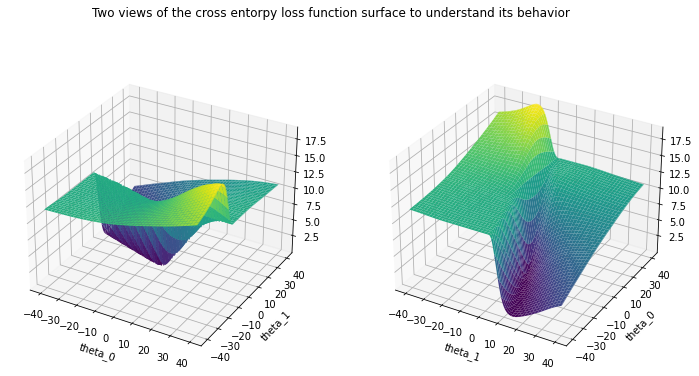

In [25]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121, projection='3d')
# Plot the surface.
ax.plot_surface(x12, x21, J12, cmap='viridis')
#ax.plot(ths1, ths2,Js12.T,'ro' )
plt.xlabel('theta_0')
plt.ylabel('theta_1')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x21, x12, J12, cmap='viridis')
#ax.plot(ths1, ths2, Js12,'ro' )
plt.xlabel('theta_1')
plt.ylabel('theta_0')


plt.suptitle('Two views of the cross entorpy loss function surface to understand its behavior')
plt.show()

## MSE Loss Function: surface and contour

In [26]:
tt1z = np.sort(np.concatenate((np.linspace(-20,0,401),np.array(ths11))))
tt2z = np.sort(np.concatenate((np.linspace(-1,6,401),np.array(ths22))))

tt12z, tt21z = np.meshgrid(tt1z, tt2z)

K12z = np.zeros((tt12z.shape[0],tt21z.shape[0]))
for i in range(tt12z.shape[0]):
    for j in range(tt21z.shape[0]):
        theta = np.array([tt12z[i,j], tt21z[i,j]])
        K12z[i,j],_= costFunction_MSE(theta, X_train_o, y_train)

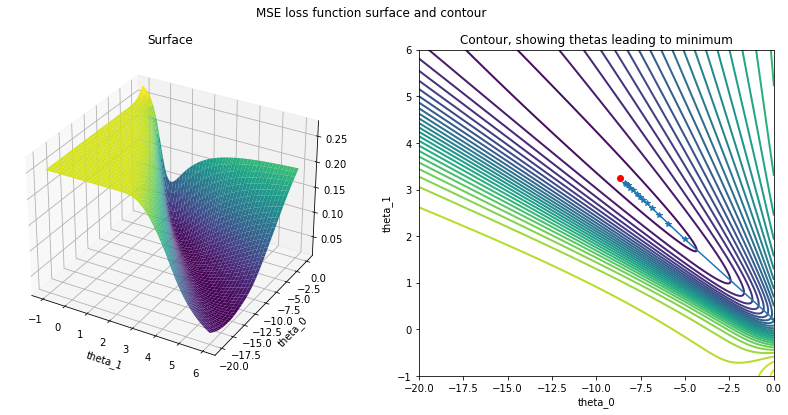

In [27]:
#Surface plot
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(tt21z, tt12z, K12z, cmap='viridis')
plt.xlabel('theta_1')
plt.ylabel('theta_0')
plt.title('Surface')
# contour plot
ax = plt.subplot(122)
plt.contour(tt1z, tt2z, K12z, linewidths=2, cmap='viridis', levels = 30)
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.plot(ths11, ths22, '-*')
plt.plot(theta_mse2[0],theta_mse2[1], 'ro')
#plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing thetas leading to minimum')
plt.suptitle('MSE loss function surface and contour')
plt.show()


We look at a zoom out over view of the surface below

In [28]:
tt1 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths11))))
tt2 = np.sort(np.concatenate((np.linspace(-80,80,801),np.array(ths22))))

tt12, tt21 = np.meshgrid(tt1, tt2)

K12 = np.zeros((tt12.shape[0],tt21.shape[0]))
for i in range(tt12.shape[0]):
    for j in range(tt21.shape[0]):
        theta = np.array([tt12[i,j], tt21[i,j]])
        K12[i,j],_= costFunction_MSE(theta, X_train_o, y_train)

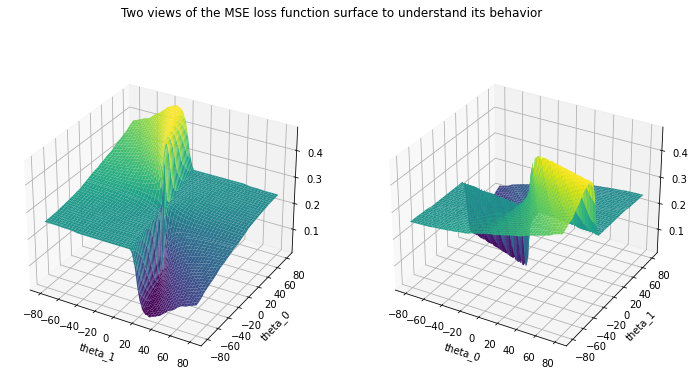

In [31]:

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121, projection='3d')
# Plot the surface.
ax.plot_surface(tt21, tt12, K12, cmap='viridis')
plt.xlabel('theta_1')
plt.ylabel('theta_0')


ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(tt12, tt21,K12, cmap='viridis')
plt.xlabel('theta_0')
plt.ylabel('theta_1')



plt.suptitle('Two views of the MSE loss function surface to understand its behavior')
plt.show()

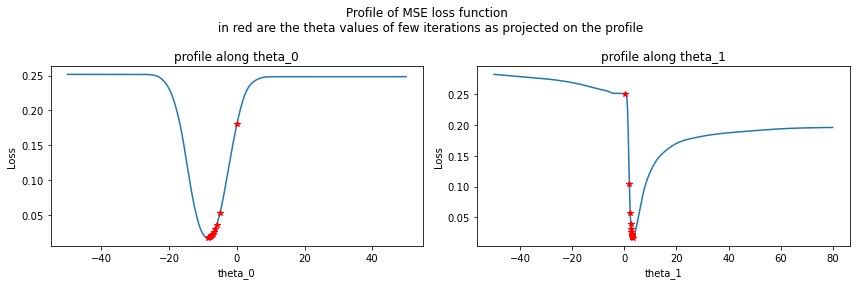

## Assessment of MSE loss function when initial values are far away from the origin
Based on the graph of the MSE loss function one is curious whether the minimizing algorithms will still converge to the same value or get stuck in other local minima. These local minima are not very clear from the sruface plot. One can only vagely realize them near the upper ridge on the graph. 

Here, we test the waters

In [35]:
N = len(range(0,40,5))
theta_mse_optm = np.zeros((N,2))
theta_mse_init = np.zeros((N,2)) 
cost_mse_2 = np.zeros(N)
for i, k in enumerate(range(0, 40, 5)):
    epsilon = k
    np.random.seed(32435)
    theta_0 = np.random.uniform(-epsilon, epsilon, 2)
    theta_mse_init[i,:] = theta_0                      
    res_mse_2 = optimize.minimize(costFunction_MSE,
                            theta_0,
                            (X_train_o, y_train),
                            jac=True,
                            method='TNC',
                            options=options)
    theta_mse_optm[i,:]= res_mse_2.x
    cost_mse_2[i] = res_mse_2.fun 

print('The range of optimal values of theta is (range = max - min)')
print(' for theta_0 %3.5f ' %(np.max(theta_mse_optm[:,0]) - np.min(theta_mse_optm[:,0])))
print(' for theta_1 %3.5f '%(np.max(theta_mse_optm[:,1]) - np.min(theta_mse_optm[:,1])))
    

The range of optimal values of theta is (range = max - min)
 for theta_0 50.05568 
 for theta_1 6.99490 


These are big ranges!! Lets plot these theta's 

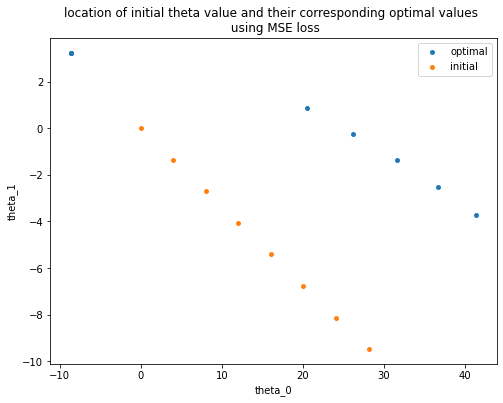

In [36]:
plt.figure(figsize = (8,6))
plt.scatter(theta_mse_optm[:,0],theta_mse_optm[:,1], s = 15)
plt.scatter(theta_mse_init[:,0],theta_mse_init[:,1], s=15)
plt.legend(['optimal', 'initial'])
plt.title('location of initial theta value and their corresponding optimal values \n using MSE loss')
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.show()

For fairness we repeat the check the cross entropy loss function to test whether the minimzation algorithm converges to one location, no matter where the initial values are located.

In [37]:
N = len(range(0,40,5))
theta_ce_optm = np.zeros((N,2))
theta_ce_init = np.zeros((N,2)) 
cost_ce_2 = np.zeros(N)
for i, k in enumerate(range(0, 40, 5)):
    epsilon = k
    np.random.seed(32435)
    theta_0 = np.random.uniform(-epsilon, epsilon, 2)
    theta_ce_init[i,:] = theta_0                      
    res_mse_2 = optimize.minimize(costFunction,
                            theta_0,
                            (X_train_o, y_train),
                            jac=True,
                            method='TNC',
                            options=options)
    theta_ce_optm[i,:]= res_mse_2.x
    cost_ce_2[i] = res_mse_2.fun 
print('The range of optimal values of theta is (range = max - min)')
print(' for theta_0 %3.5f ' %(np.max(theta_ce_optm[:,0]) - np.min(theta_ce_optm[:,0])))
print(' for theta_1 %3.5f '%(np.max(theta_ce_optm[:,1]) - np.min(theta_ce_optm[:,1])))
  

The range of optimal values of theta is (range = max - min)
 for theta_0 0.00303 
 for theta_1 0.00108 


These ranges of values are more realistic indicating all initial values eventually converge to the same value.